<a href="https://colab.research.google.com/github/Vijce/Group-16-Final-Project/blob/main/Pseudo_Label_Fine_Tuning_MLPClassifier_V02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error


# Load Data

In [62]:
df_department = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JMU/Practical Data Science/Assignments/Final Project/company_department_file_v2.csv')

display(df_department)
display(df_department.isna().sum())
pd.unique(df_department['label'])

,text,label
0,Adjoint directeur communication,Marketing
1,Advisor Strategy and Projects,Project Management
2,Beratung & Projekte,Project Management
3,Beratung & Projektmanagement,Project Management
4,Beratung und Projektmanagement kommunale Partner,Project Management
...,...,...
10140,VP Sales D.A.CH.,Sales
10141,VP Sales DACH,Sales
10142,VP Sales Development & Strategy,Sales
10143,VP Sales Germany,Sales


,0
text,0
label,0


array(['Marketing', 'Project Management', 'Administrative',
       'Business Development', 'Consulting', 'Human Resources',
       'Information Technology', 'Other', 'Purchasing', 'Sales',
       'Customer Support'], dtype=object)

In [63]:
df_department['text'] = df_department['text'].str.lower()
df_department

,text,label
0,adjoint directeur communication,Marketing
1,advisor strategy and projects,Project Management
2,beratung & projekte,Project Management
3,beratung & projektmanagement,Project Management
4,beratung und projektmanagement kommunale partner,Project Management
...,...,...
10140,vp sales d.a.ch.,Sales
10141,vp sales dach,Sales
10142,vp sales development & strategy,Sales
10143,vp sales germany,Sales


In [64]:
df_seniority = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JMU/Practical Data Science/Assignments/Final Project/seniority_label_v2.csv')

display(df_seniority, df_seniority.isna().sum())
pd.unique(df_seniority['label'])

,text,label
0,Analyst,Junior
1,Analyste financier,Junior
2,Anwendungstechnischer Mitarbeiter,Junior
3,Application Engineer,Senior
4,Applications Engineer,Senior
...,...,...
9423,VP Sales D.A.CH.,Management
9424,VP Sales DACH,Management
9425,VP Sales Development & Strategy,Management
9426,VP Sales Germany,Management


,0
text,0
label,0


array(['Junior', 'Senior', 'Lead', 'Management', 'Director'], dtype=object)

In [65]:
df_seniority['text'] = df_seniority['text'].str.lower()

df_seniority

,text,label
0,analyst,Junior
1,analyste financier,Junior
2,anwendungstechnischer mitarbeiter,Junior
3,application engineer,Senior
4,applications engineer,Senior
...,...,...
9423,vp sales d.a.ch.,Management
9424,vp sales dach,Management
9425,vp sales development & strategy,Management
9426,vp sales germany,Management


In [227]:
import json

file_path_annotated = '/content/drive/MyDrive/Colab Notebooks/JMU/Practical Data Science/Assignments/Final Project/linkedin-cvs-annotated_test_data_set (training data).json'

file_path_tobepredict = '/content/drive/MyDrive/Colab Notebooks/JMU/Practical Data Science/Assignments/Final Project/linkedin-cvs-not-annotated_to_be_predicted.json'

def read_json_file(file_path):
  with open(file_path, 'r') as file:
      jason_data = json.load(file)

  flat_data = []
  for item in jason_data:
      for subitem in item:
          flat_data.append(subitem)

  df = pd.DataFrame(flat_data)
  return df

df = read_json_file(file_path_annotated)
df_predict = read_json_file(file_path_tobepredict)

display(df,df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   organization  2638 non-null   object
 1   linkedin      2638 non-null   object
 2   position      2638 non-null   object
 3   startDate     2520 non-null   object
 4   endDate       1897 non-null   object
 5   status        2638 non-null   object
 6   department    2638 non-null   object
 7   seniority     2638 non-null   object
dtypes: object(8)
memory usage: 165.0+ KB


,organization,linkedin,position,startDate,endDate,status,department,seniority
0,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Prokurist,2019-08,None,ACTIVE,Other,Management
1,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,CFO,2019-07,None,ACTIVE,Other,Management
2,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Betriebswirtin,2019-07,None,ACTIVE,Other,Professional
3,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Prokuristin,2019-07,None,ACTIVE,Other,Management
4,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,CFO,2019-07,None,ACTIVE,Other,Management
...,...,...,...,...,...,...,...,...
2633,Bistum,,Justitiar,2014-03,None,ACTIVE,Other,Professional
2634,FORESTA Management,,Geschäftsführer,2010-01,None,ACTIVE,Other,Management
2635,Malteser Hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,Präsidium,1999,None,ACTIVE,Other,Management
2636,Spies & Brunner RAe,,Rechtsanwalt,1995-01,None,ACTIVE,Other,Professional


None

In [67]:
df[['position', 'status', 'organization']] = df[['position', 'status', 'organization']].apply(lambda x: x.str.lower())

df

,organization,linkedin,position,startDate,endDate,status,department,seniority
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
...,...,...,...,...,...,...,...,...
2633,bistum,,justitiar,2014-03,None,active,Other,Professional
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management
2636,spies & brunner rae,,rechtsanwalt,1995-01,None,active,Other,Professional


In [68]:
df['status'].value_counts()

,count
status,
inactive,1897
active,623
unknown,118


In [69]:
df_linkedin = df.copy()
df_linkedin = df_linkedin[df_linkedin['status'] == 'active']

df_linkedin

,organization,linkedin,position,startDate,endDate,status,department,seniority
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management
...,...,...,...,...,...,...,...,...
2632,malteserorden,,kanzler der deutschen assoziation,2015-01,None,active,Other,Management
2633,bistum,,justitiar,2014-03,None,active,Other,Professional
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management


In [70]:
df_linkedin.isna().sum()

,0
organization,0
linkedin,0
position,0
startDate,0
endDate,623
status,0
department,0
seniority,0


In [71]:
display(df_predict,df_predict.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   organization  1886 non-null   object
 1   linkedin      1886 non-null   object
 2   position      1886 non-null   object
 3   startDate     1828 non-null   object
 4   endDate       1409 non-null   object
 5   status        1886 non-null   object
dtypes: object(6)
memory usage: 88.5+ KB


,organization,linkedin,position,startDate,endDate,status
0,"Keeping The Books, Bookkeeping",,Bookkeeper,2023-03,None,ACTIVE
1,Playful Paws,,Co-Owner,2018-11,None,ACTIVE
2,S&R services,,Logistics Officer,2019-09,2024-04,INACTIVE
3,ABC Supply Co. Inc.,https://www.linkedin.com/company/abc-supply,Truck driver/ laborer,2019-03,2019-09,INACTIVE
4,MB Railways,,Fuel Driver,2018-03,2019-03,INACTIVE
...,...,...,...,...,...,...
1881,Euler Hermes Deutschland,https://www.linkedin.com/company/allianz-trade...,Juristischer Berater,1996-03,None,ACTIVE
1882,Folkwang Universität der Künste,,"Leitung Personal, Finanzen, Einkauf, IT | Folk...",2015-07,None,ACTIVE
1883,Landesspracheninstitut in der Ruhr-Universität...,,Verwaltungsleitung Landesspracheninstitut in d...,2005-10,2015-06,INACTIVE
1884,Folkwang Universität der Künste,,"Leitung Gebäudemanagement, Einkauf und Control...",2004-03,2005-09,INACTIVE


None

In [72]:
df_predict[['position', 'status', 'organization']] = df_predict[['position', 'status', 'organization']].apply(lambda x: x.str.lower())

df_predict

,organization,linkedin,position,startDate,endDate,status
0,"keeping the books, bookkeeping",,bookkeeper,2023-03,None,active
1,playful paws,,co-owner,2018-11,None,active
2,s&r services,,logistics officer,2019-09,2024-04,inactive
3,abc supply co. inc.,https://www.linkedin.com/company/abc-supply,truck driver/ laborer,2019-03,2019-09,inactive
4,mb railways,,fuel driver,2018-03,2019-03,inactive
...,...,...,...,...,...,...
1881,euler hermes deutschland,https://www.linkedin.com/company/allianz-trade...,juristischer berater,1996-03,None,active
1882,folkwang universität der künste,,"leitung personal, finanzen, einkauf, it | folk...",2015-07,None,active
1883,landesspracheninstitut in der ruhr-universität...,,verwaltungsleitung landesspracheninstitut in d...,2005-10,2015-06,inactive
1884,folkwang universität der künste,,"leitung gebäudemanagement, einkauf und control...",2004-03,2005-09,inactive


In [73]:
df_predict.isna().sum()

,0
organization,0
linkedin,0
position,0
startDate,58
endDate,477
status,0


# 1. Rule-based matching

Pure text matching.

Using csv of department and seniority data as reference to predic JSON linkedin data

In [74]:
department_list = [(row['text'], row['label']) for index, row in df_department.iterrows()]

seniority_list = [(row['text'], row['label']) for index, row in df_seniority.iterrows()]

df_linkedin_textmatch = df_linkedin.copy()

X_base = df_linkedin_textmatch['position']
y_base_dept = df_linkedin_textmatch['department']
y_base_seni = df_linkedin_textmatch['seniority']

def predict_department(X_base):
    for text, label in department_list:
        if text in X_base:
            return label
    return 'Other'

def predict_seniority(X_base):
    for text, label in seniority_list:
        if text in X_base:
            return label
    return 'Other'

df_linkedin_textmatch['predict_label_dept'] = X_base.apply(predict_department)
df_linkedin_textmatch['predict_label_seni'] = X_base.apply(predict_seniority)

accuracy_dept = accuracy_score(y_base_dept, df_linkedin_textmatch['predict_label_dept'])
accuracy_seni = accuracy_score(y_base_seni, df_linkedin_textmatch['predict_label_seni'])

print(f'Department Prediction Accuracy: {accuracy_dept}')
print(f'Seniority Prediction Accuracy: {accuracy_seni}')

Department Prediction Accuracy: 0.622792937399679
Seniority Prediction Accuracy: 0.35313001605136435


In [75]:
df_linkedin_textmatch

,organization,linkedin,position,startDate,endDate,status,department,seniority,predict_label_dept,predict_label_seni
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management,Other,Other
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management,Other,Other
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional,Other,Other
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management,Other,Other
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management,Other,Other
...,...,...,...,...,...,...,...,...,...,...
2632,malteserorden,,kanzler der deutschen assoziation,2015-01,None,active,Other,Management,Other,Other
2633,bistum,,justitiar,2014-03,None,active,Other,Professional,Information Technology,Other
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management,Other,Other


Manual splitting original text into a set of words.

The matching accuracy improved little.

In [76]:
df_linkedin_match = df_linkedin.copy()

department_keywords = [
    (set(row['text'].split()), row['label'])
    for index, row in df_department.iterrows()
]

seniority_keywords = [
    (set(row['text'].split()), row['label'])
    for index, row in df_seniority.iterrows()
]

def predict_department_set(X_base):
    position_tokens = set(X_base.split())
    for keyword, label in department_keywords:
        if keyword.issubset(position_tokens):
            return label
    return 'Other'

def predict_seniority_set(X_base):
    position_tokens = set(X_base.split())
    for keyword, label in seniority_keywords:
        if keyword.issubset(position_tokens):
            return label
    return 'Other'

df_linkedin_match['predict_label_dept'] = X_base.apply(predict_department_set)
df_linkedin_match['predict_label_seni'] = X_base.apply(predict_seniority_set)

accuracy_dept = accuracy_score(y_base_dept, df_linkedin_match['predict_label_dept'])
accuracy_seni = accuracy_score(y_base_seni, df_linkedin_match['predict_label_seni'])

print(f'Department Prediction Accuracy: {accuracy_dept}')
print(f'Seniority Prediction Accuracy: {accuracy_seni}')


Department Prediction Accuracy: 0.6837881219903692
Seniority Prediction Accuracy: 0.33386837881219905


In [77]:
df_linkedin_match

,organization,linkedin,position,startDate,endDate,status,department,seniority,predict_label_dept,predict_label_seni
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management,Other,Other
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management,Other,Other
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional,Other,Other
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management,Other,Other
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management,Other,Other
...,...,...,...,...,...,...,...,...,...,...
2632,malteserorden,,kanzler der deutschen assoziation,2015-01,None,active,Other,Management,Other,Other
2633,bistum,,justitiar,2014-03,None,active,Other,Professional,Other,Other
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management,Other,Other


##Pseudo-Labels for non-annotated LinkedIn

In [78]:
df_predict_match = df_predict.copy()
df_predict_match['predict_label_dept'] = X_base.apply(predict_department_set)
df_predict_match['predict_label_seni'] = X_base.apply(predict_seniority_set)
df_predict_match

,organization,linkedin,position,startDate,endDate,status,predict_label_dept,predict_label_seni
0,"keeping the books, bookkeeping",,bookkeeper,2023-03,None,active,Other,Other
1,playful paws,,co-owner,2018-11,None,active,Other,Other
2,s&r services,,logistics officer,2019-09,2024-04,inactive,Other,Other
3,abc supply co. inc.,https://www.linkedin.com/company/abc-supply,truck driver/ laborer,2019-03,2019-09,inactive,Other,Other
4,mb railways,,fuel driver,2018-03,2019-03,inactive,Other,Other
...,...,...,...,...,...,...,...,...
1881,euler hermes deutschland,https://www.linkedin.com/company/allianz-trade...,juristischer berater,1996-03,None,active,Information Technology,Other
1882,folkwang universität der künste,,"leitung personal, finanzen, einkauf, it | folk...",2015-07,None,active,Other,Management
1883,landesspracheninstitut in der ruhr-universität...,,verwaltungsleitung landesspracheninstitut in d...,2005-10,2015-06,inactive,Other,Other
1884,folkwang universität der künste,,"leitung gebäudemanagement, einkauf und control...",2004-03,2005-09,inactive,NaN,NaN


# 2. ML Models

## Scikit-Learn: Embedding + MLPClassifier

I ask AI: what model should I choose for text embedding.

**AI response:**

The all-MiniLM-L6-v2 model is often selected as a primary choice for text embedding tasks because it offers a high performance-to-size ratio. It is specifically designed to balance speed, memory efficiency, and accuracy for general-purpose semantic tasks.

Key Reasons to Choose all-MiniLM-L6-v2

1. Extreme Efficiency and Speed

Compact Size: The model is remarkably small—approximately 80 MB (some versions as small as 22 MB)—making it easy to load and deploy on devices with limited resources.

Inference Speed: It is roughly 5 times faster than larger models like all-mpnet-base-v2. It can process up to 14,200 sentence pairs per second on a CPU, which is critical for real-time applications or processing large datasets like yours.

2. Strong Semantic Understanding

Training Foundation: Despite its small size, it was trained on over 1 billion sentence pairs using a self-supervised contrastive learning objective.

Semantic Mapping: It maps text into a 384-dimensional dense vector space. This allows it to capture the underlying meaning of words so that "I need a job" and "I am searching for a new opportunity" result in very similar mathematical vectors.

3. Versatility for Baseline Models

Zero-Shot Ready: It is pre-trained as a general-purpose model, meaning it can often correctly classify labels it has never seen before by comparing the similarity between label text and input text.

Broad Coverage: It provides broader conceptual coverage than older techniques like TF-IDF, which only look for exact word matches.

In [79]:
from sentence_transformers import SentenceTransformer

In [80]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [81]:
def emb_split(df, model, test_size):
  X = df['text']
  X_emb = model.encode(X.tolist())
  y = df['label']
  X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=test_size, random_state=42)
  return X_train, X_test, y_train, y_test


In [82]:
X_train_emb_dept, X_test_emb_dept, y_train_emb_dept, y_test_emb_dept = emb_split(df_department, model, 0.2)

X_train_emb_seni, X_test_emb_seni, y_train_emb_seni, y_test_emb_seni = emb_split(df_seniority, model, 0.2)

In [83]:
from sklearn.base import clone

In [84]:
mlpc = MLPClassifier(max_iter=500, alpha=0.01, hidden_layer_sizes=(50,), random_state=42)

mlpc_dept_emb = clone(mlpc)
mlpc_dept_emb.fit(X_train_emb_dept, y_train_emb_dept)

mlpc_seni_emb = clone(mlpc)
mlpc_seni_emb.fit(X_train_emb_seni, y_train_emb_seni)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(50,), max_iter=500,
              random_state=42)

In [85]:
def evaluation_report(model, X, y):
  predict = model.predict(X)
  report = classification_report(
      y,
      predict,
      output_dict=True
  )

  return report

####Department csv model evaluation

In [86]:
mlpc_emb_dept_insample_report = evaluation_report(mlpc_dept_emb, X_train_emb_dept, y_train_emb_dept)

pd.DataFrame(mlpc_emb_dept_insample_report).T

,precision,recall,f1-score,support
Administrative,1.0,1.0,1.0,72.0
Business Development,1.0,1.0,1.0,480.0
Consulting,1.0,1.0,1.0,134.0
Customer Support,1.0,1.0,1.0,23.0
Human Resources,1.0,1.0,1.0,26.0
Information Technology,1.0,1.0,1.0,1041.0
Marketing,1.0,1.0,1.0,3441.0
Other,1.0,1.0,1.0,30.0
Project Management,1.0,1.0,1.0,168.0
Purchasing,1.0,1.0,1.0,33.0


In [87]:
mlcp_emb_dept_report = evaluation_report(mlpc_dept_emb, X_test_emb_dept, y_test_emb_dept)
pd.DataFrame(mlcp_emb_dept_report).T

,precision,recall,f1-score,support
Administrative,1.000000,0.909091,0.952381,11.000000
Business Development,0.950355,0.957143,0.953737,140.000000
Consulting,0.896552,0.787879,0.838710,33.000000
Customer Support,1.000000,0.700000,0.823529,10.000000
Human Resources,0.800000,0.800000,0.800000,5.000000
Information Technology,0.926471,0.954545,0.940299,264.000000
Marketing,0.989474,0.990632,0.990053,854.000000
Other,1.000000,0.916667,0.956522,12.000000
Project Management,0.933333,0.848485,0.888889,33.000000
Purchasing,0.857143,0.857143,0.857143,7.000000


####LinkedIN department prediction evaluation

In [88]:
linkedin_emb = model.encode(df_linkedin['position'].tolist())

mlcp_emb_linkedin_dept_report = evaluation_report(mlpc_dept_emb, linkedin_emb, df_linkedin['department'])

linkedin_dept_initial=pd.DataFrame(mlcp_emb_linkedin_dept_report).T
linkedin_dept_initial

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
Administrative,0.250000,0.071429,0.111111,14.000000
Business Development,0.225806,0.350000,0.274510,20.000000
Consulting,0.444444,0.512821,0.476190,39.000000
Customer Support,0.000000,0.000000,0.000000,6.000000
Human Resources,0.857143,0.375000,0.521739,16.000000
Information Technology,0.143322,0.709677,0.238482,62.000000
Marketing,0.220339,0.590909,0.320988,22.000000
Other,0.571429,0.011628,0.022792,344.000000
Project Management,0.489362,0.589744,0.534884,39.000000
Purchasing,0.875000,0.466667,0.608696,15.000000


###Seniority csv model evaluation

In [89]:
mlpc_emb_seni_insample_report = evaluation_report(mlpc_seni_emb, X_train_emb_seni, y_train_emb_seni)

pd.DataFrame(mlpc_emb_seni_insample_report).T

,precision,recall,f1-score,support
Director,1.0,1.0,1.0,782.0
Junior,1.0,1.0,1.0,310.0
Lead,1.0,1.0,1.0,2837.0
Management,1.0,1.0,1.0,602.0
Senior,1.0,1.0,1.0,3011.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,7542.0
weighted avg,1.0,1.0,1.0,7542.0


In [90]:
mlpc_emb_seni_report = evaluation_report(mlpc_seni_emb, X_test_emb_seni, y_test_emb_seni)
pd.DataFrame(mlpc_emb_seni_report).T

,precision,recall,f1-score,support
Director,0.994924,0.970297,0.982456,202.000000
Junior,0.989130,0.919192,0.952880,99.000000
Lead,0.967922,0.978843,0.973352,709.000000
Management,0.921569,0.915584,0.918567,154.000000
Senior,0.969739,0.976454,0.973085,722.000000
accuracy,0.968717,0.968717,0.968717,0.968717
macro avg,0.968657,0.952074,0.960068,1886.000000
weighted avg,0.968838,0.968717,0.968677,1886.000000


###LinkedIN seniority prediction evaluation

In [91]:
mlcp_emb_linkedin_seni_report = evaluation_report(mlpc_seni_emb, linkedin_emb, df_linkedin['seniority'])

pd.DataFrame(mlcp_emb_linkedin_seni_report).T


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
Director,0.534483,0.911765,0.673913,34.00000
Junior,0.079365,0.416667,0.133333,12.00000
Lead,0.503546,0.568000,0.533835,125.00000
Management,0.826087,0.593750,0.690909,192.00000
Professional,0.000000,0.000000,0.000000,216.00000
Senior,0.161435,0.818182,0.269663,44.00000
accuracy,0.412520,0.412520,0.412520,0.41252
macro avg,0.350819,0.551394,0.383609,623.00000
weighted avg,0.397721,0.412520,0.378430,623.00000


# Fine-tuning department prediction

## Pseudo Labels from token-matched model 1 (linkedin file)

for experimenting only

In [92]:
df_pseudo = df_linkedin_match.copy()
df_pseudo

,organization,linkedin,position,startDate,endDate,status,department,seniority,predict_label_dept,predict_label_seni
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management,Other,Other
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management,Other,Other
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional,Other,Other
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management,Other,Other
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management,Other,Other
...,...,...,...,...,...,...,...,...,...,...
2632,malteserorden,,kanzler der deutschen assoziation,2015-01,None,active,Other,Management,Other,Other
2633,bistum,,justitiar,2014-03,None,active,Other,Professional,Other,Other
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management,Other,Other


In [93]:
df_pseudo['predict_label_dept'].value_counts()

,count
predict_label_dept,
Other,511
Sales,28
Project Management,19
Consulting,19
Information Technology,14
Business Development,13
Marketing,11
Purchasing,6
Administrative,1


In [94]:
df_pseudo = df_pseudo[['position', 'predict_label_dept']]
df_pseudo = df_pseudo.rename(columns={
    'position': 'text',
    'predict_label_dept': 'label'
})
df_pseudo

,text,label
0,prokurist,Other
1,cfo,Other
2,betriebswirtin,Other
3,prokuristin,Other
4,cfo,Other
...,...,...
2632,kanzler der deutschen assoziation,Other
2633,justitiar,Other
2634,geschäftsführer,Other
2635,präsidium,Other


In [95]:
df_department

,text,label
0,adjoint directeur communication,Marketing
1,advisor strategy and projects,Project Management
2,beratung & projekte,Project Management
3,beratung & projektmanagement,Project Management
4,beratung und projektmanagement kommunale partner,Project Management
...,...,...
10140,vp sales d.a.ch.,Sales
10141,vp sales dach,Sales
10142,vp sales development & strategy,Sales
10143,vp sales germany,Sales


In [96]:
df_dept = df_department.copy()
df_dept_aug = pd.concat([df_dept, df_pseudo])
df_dept_aug


,text,label
0,adjoint directeur communication,Marketing
1,advisor strategy and projects,Project Management
2,beratung & projekte,Project Management
3,beratung & projektmanagement,Project Management
4,beratung und projektmanagement kommunale partner,Project Management
...,...,...
2632,kanzler der deutschen assoziation,Other
2633,justitiar,Other
2634,geschäftsführer,Other
2635,präsidium,Other


In [97]:
X_train_dept_aug, X_test_dept_aug, y_train_dept_aug, y_test_dept_aug = emb_split(df_dept_aug, model, 0.2)

In [98]:
mlpc_finetuned = MLPClassifier(max_iter=500, alpha=0.05, hidden_layer_sizes=(50,), random_state=42)

In [99]:
mlpc_dept_aug = clone(mlpc_finetuned)
mlpc_dept_aug.fit(X_train_dept_aug, y_train_dept_aug)


MLPClassifier(alpha=0.05, hidden_layer_sizes=(50,), max_iter=500,
              random_state=42)

In [100]:
mlpc_dept_aug_report =  evaluation_report(mlpc_dept_aug, X_test_dept_aug, y_test_dept_aug)

pd.DataFrame(mlpc_dept_aug_report).T


,precision,recall,f1-score,support
Administrative,1.000000,0.875000,0.933333,8.000000
Business Development,0.978417,0.944444,0.961131,144.000000
Consulting,0.794872,0.837838,0.815789,37.000000
Customer Support,1.000000,0.272727,0.428571,11.000000
Human Resources,0.714286,0.833333,0.769231,6.000000
Information Technology,0.892086,0.942966,0.916821,263.000000
Marketing,0.978723,0.985714,0.982206,840.000000
Other,0.866071,0.795082,0.829060,122.000000
Project Management,0.930233,0.816327,0.869565,49.000000
Purchasing,0.888889,0.666667,0.761905,12.000000


## LinkedIn department prediction

In [101]:
linkedin_emb = model.encode(df_linkedin['position'].tolist())

mlcp_linkedin_dept_aug_report = evaluation_report(mlpc_dept_aug, linkedin_emb, df_linkedin['department'])

linkedin_dept_finetune = pd.DataFrame(mlcp_linkedin_dept_aug_report).T
linkedin_dept_finetune

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
Administrative,1.000000,0.071429,0.133333,14.000000
Business Development,0.461538,0.300000,0.363636,20.000000
Consulting,0.947368,0.461538,0.620690,39.000000
Customer Support,0.000000,0.000000,0.000000,6.000000
Human Resources,0.750000,0.187500,0.300000,16.000000
Information Technology,0.541667,0.209677,0.302326,62.000000
Marketing,0.578947,0.500000,0.536585,22.000000
Other,0.688034,0.936047,0.793103,344.000000
Project Management,0.863636,0.487179,0.622951,39.000000
Purchasing,1.000000,0.466667,0.636364,15.000000


In [102]:
linkedin_dept_finetune = linkedin_dept_finetune.reset_index()
linkedin_dept_finetune = linkedin_dept_finetune.rename(columns={
    'index': 'label',
    'f1-score': 'finetune_f1_score'
})

linkedin_dept_finetune

,label,precision,recall,finetune_f1_score,support
0,Administrative,1.000000,0.071429,0.133333,14.000000
1,Business Development,0.461538,0.300000,0.363636,20.000000
2,Consulting,0.947368,0.461538,0.620690,39.000000
3,Customer Support,0.000000,0.000000,0.000000,6.000000
4,Human Resources,0.750000,0.187500,0.300000,16.000000
5,Information Technology,0.541667,0.209677,0.302326,62.000000
6,Marketing,0.578947,0.500000,0.536585,22.000000
7,Other,0.688034,0.936047,0.793103,344.000000
8,Project Management,0.863636,0.487179,0.622951,39.000000
9,Purchasing,1.000000,0.466667,0.636364,15.000000


In [103]:
linkedin_dept_initial = linkedin_dept_initial.reset_index()

linkedin_dept_initial = linkedin_dept_initial.rename(columns={
    'index': 'label',
    'f1-score': 'initial_f1_score'
})

linkedin_dept_initial

,label,precision,recall,initial_f1_score,support
0,Administrative,0.250000,0.071429,0.111111,14.000000
1,Business Development,0.225806,0.350000,0.274510,20.000000
2,Consulting,0.444444,0.512821,0.476190,39.000000
3,Customer Support,0.000000,0.000000,0.000000,6.000000
4,Human Resources,0.857143,0.375000,0.521739,16.000000
5,Information Technology,0.143322,0.709677,0.238482,62.000000
6,Marketing,0.220339,0.590909,0.320988,22.000000
7,Other,0.571429,0.011628,0.022792,344.000000
8,Project Management,0.489362,0.589744,0.534884,39.000000
9,Purchasing,0.875000,0.466667,0.608696,15.000000


In [104]:
linkedin_dept_merge = pd.merge(linkedin_dept_initial, linkedin_dept_finetune, on='label')

linkedin_dept_merge = linkedin_dept_merge[['label', 'initial_f1_score', 'finetune_f1_score']]

linkedin_dept_merge

,label,initial_f1_score,finetune_f1_score
0,Administrative,0.111111,0.133333
1,Business Development,0.274510,0.363636
2,Consulting,0.476190,0.620690
3,Customer Support,0.000000,0.000000
4,Human Resources,0.521739,0.300000
5,Information Technology,0.238482,0.302326
6,Marketing,0.320988,0.536585
7,Other,0.022792,0.793103
8,Project Management,0.534884,0.622951
9,Purchasing,0.608696,0.636364


In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
df_plot_performance = linkedin_dept_merge[
    (linkedin_dept_merge['label'] == 'accuracy') |
    (linkedin_dept_merge['label'] == 'macro avg') |
    (linkedin_dept_merge['label'] == 'weighted avg')
].copy()

df_performance_melted = df_plot_performance.melt(id_vars='label', var_name='type', value_name='f1_score')

df_performance_melted['type'] = df_performance_melted['type'].replace({'initial_f1_score': 'Initial', 'finetune_f1_score': 'Fine-tuned'})

df_performance_melted

,label,type,f1_score
0,accuracy,Initial,0.258427
1,macro avg,Initial,0.325175
2,weighted avg,Initial,0.184832
3,accuracy,Fine-tuned,0.691814
4,macro avg,Fine-tuned,0.452991
5,weighted avg,Fine-tuned,0.652269


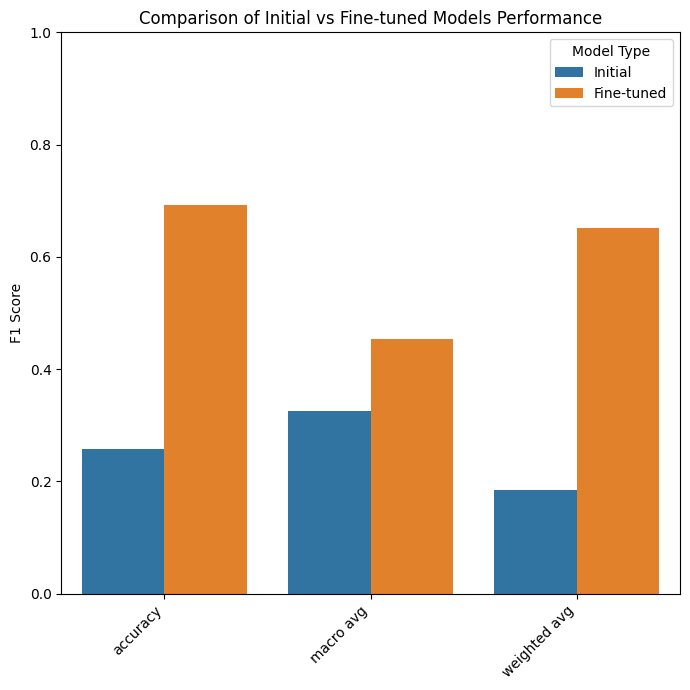

In [107]:
plt.figure(figsize=(7, 7))
sns.barplot(x='label', y='f1_score', hue='type', data=df_performance_melted)

plt.title('Comparison of Initial vs Fine-tuned Models Performance')
plt.xlabel('')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title='Model Type')
plt.tight_layout()
plt.show()

In [108]:
df_plot = linkedin_dept_merge[
    (linkedin_dept_merge['label'] != 'accuracy') &
    (linkedin_dept_merge['label'] != 'macro avg') &
    (linkedin_dept_merge['label'] != 'weighted avg')
].copy()

df_melted = df_plot.melt(id_vars='label', var_name='type', value_name='F1 Score')

df_melted['type'] = df_melted['type'].replace({'initial_f1_score': 'Initial', 'finetune_f1_score': 'Fine-tuned'})

df_melted

,label,type,F1 Score
0,Administrative,Initial,0.111111
1,Business Development,Initial,0.274510
2,Consulting,Initial,0.476190
3,Customer Support,Initial,0.000000
4,Human Resources,Initial,0.521739
5,Information Technology,Initial,0.238482
6,Marketing,Initial,0.320988
7,Other,Initial,0.022792
8,Project Management,Initial,0.534884
9,Purchasing,Initial,0.608696


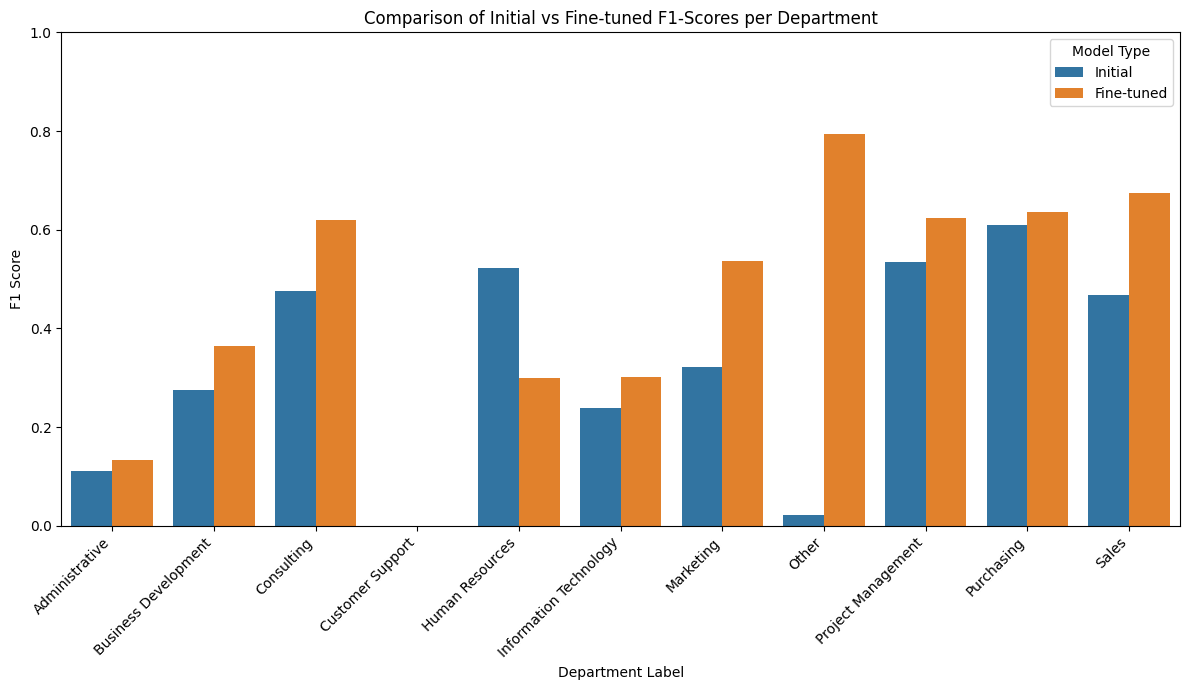

In [109]:
plt.figure(figsize=(12, 7))
sns.barplot(x='label', y='F1 Score', hue='type', data=df_melted,)

plt.title('Comparison of Initial vs Fine-tuned F1-Scores per Department')
plt.xlabel('Department Label')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title='Model Type')
plt.tight_layout()
plt.show()

## Prediction for unannotated LinkedIn file

In [110]:
df_predict

,organization,linkedin,position,startDate,endDate,status
0,"keeping the books, bookkeeping",,bookkeeper,2023-03,None,active
1,playful paws,,co-owner,2018-11,None,active
2,s&r services,,logistics officer,2019-09,2024-04,inactive
3,abc supply co. inc.,https://www.linkedin.com/company/abc-supply,truck driver/ laborer,2019-03,2019-09,inactive
4,mb railways,,fuel driver,2018-03,2019-03,inactive
...,...,...,...,...,...,...
1881,euler hermes deutschland,https://www.linkedin.com/company/allianz-trade...,juristischer berater,1996-03,None,active
1882,folkwang universität der künste,,"leitung personal, finanzen, einkauf, it | folk...",2015-07,None,active
1883,landesspracheninstitut in der ruhr-universität...,,verwaltungsleitung landesspracheninstitut in d...,2005-10,2015-06,inactive
1884,folkwang universität der künste,,"leitung gebäudemanagement, einkauf und control...",2004-03,2005-09,inactive


In [111]:
df_predict_emb = model.encode(df_predict['position'].tolist())
df_predict['predict_label_dept'] = mlpc_dept_aug.predict(df_predict_emb)
df_predict

,organization,linkedin,position,startDate,endDate,status,predict_label_dept
0,"keeping the books, bookkeeping",,bookkeeper,2023-03,None,active,Other
1,playful paws,,co-owner,2018-11,None,active,Other
2,s&r services,,logistics officer,2019-09,2024-04,inactive,Other
3,abc supply co. inc.,https://www.linkedin.com/company/abc-supply,truck driver/ laborer,2019-03,2019-09,inactive,Other
4,mb railways,,fuel driver,2018-03,2019-03,inactive,Other
...,...,...,...,...,...,...,...
1881,euler hermes deutschland,https://www.linkedin.com/company/allianz-trade...,juristischer berater,1996-03,None,active,Other
1882,folkwang universität der künste,,"leitung personal, finanzen, einkauf, it | folk...",2015-07,None,active,Purchasing
1883,landesspracheninstitut in der ruhr-universität...,,verwaltungsleitung landesspracheninstitut in d...,2005-10,2015-06,inactive,Other
1884,folkwang universität der künste,,"leitung gebäudemanagement, einkauf und control...",2004-03,2005-09,inactive,Purchasing


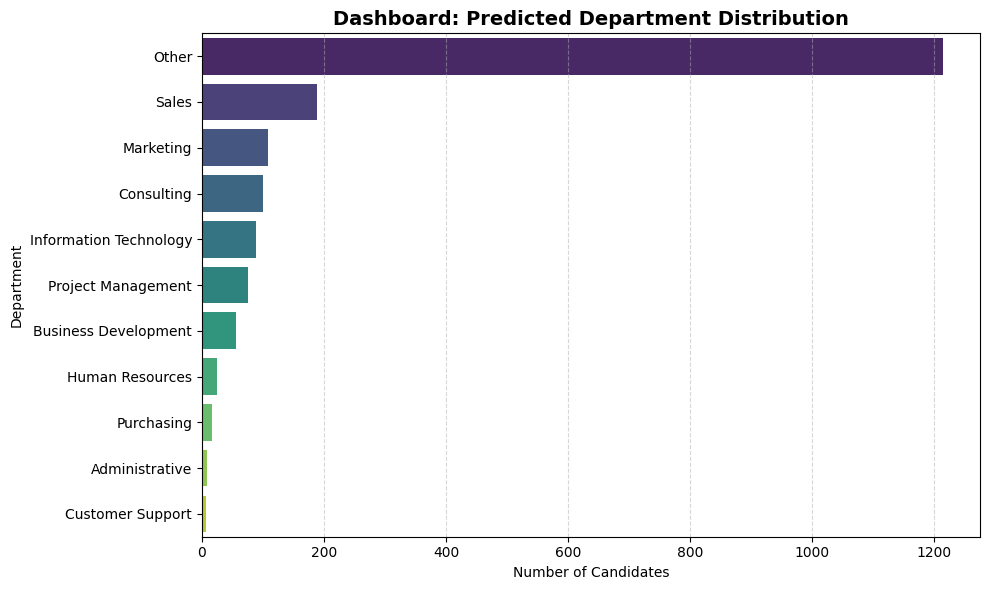

In [112]:
dept_counts = df_predict['predict_label_dept'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=dept_counts.values, y=dept_counts.index, palette='viridis', hue=dept_counts.index, legend=False)

plt.title('Dashboard: Predicted Department Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Candidates')
plt.ylabel('Department')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

##Pseudo Labels from token-matched model 2 (non-annotated linkedin file)

In [207]:
df_pseudo_predic = df_predict_match.copy()
df_pseudo_predic

,organization,linkedin,position,startDate,endDate,status,predict_label_dept,predict_label_seni
0,"keeping the books, bookkeeping",,bookkeeper,2023-03,None,active,Other,Other
1,playful paws,,co-owner,2018-11,None,active,Other,Other
2,s&r services,,logistics officer,2019-09,2024-04,inactive,Other,Other
3,abc supply co. inc.,https://www.linkedin.com/company/abc-supply,truck driver/ laborer,2019-03,2019-09,inactive,Other,Other
4,mb railways,,fuel driver,2018-03,2019-03,inactive,Other,Other
...,...,...,...,...,...,...,...,...
1881,euler hermes deutschland,https://www.linkedin.com/company/allianz-trade...,juristischer berater,1996-03,None,active,Information Technology,Other
1882,folkwang universität der künste,,"leitung personal, finanzen, einkauf, it | folk...",2015-07,None,active,Other,Management
1883,landesspracheninstitut in der ruhr-universität...,,verwaltungsleitung landesspracheninstitut in d...,2005-10,2015-06,inactive,Other,Other
1884,folkwang universität der künste,,"leitung gebäudemanagement, einkauf und control...",2004-03,2005-09,inactive,NaN,NaN


In [210]:
df_pseudo_predic.isnull().sum()

,0
organization,0
linkedin,0
position,0
startDate,58
endDate,477
status,0
predict_label_dept,1456
predict_label_seni,1456


In [211]:
df_pseudo_predic = df_pseudo_predic.dropna(subset=['predict_label_dept'])
df_pseudo_predic

,organization,linkedin,position,startDate,endDate,status,predict_label_dept,predict_label_seni
0,"keeping the books, bookkeeping",,bookkeeper,2023-03,None,active,Other,Other
1,playful paws,,co-owner,2018-11,None,active,Other,Other
2,s&r services,,logistics officer,2019-09,2024-04,inactive,Other,Other
3,abc supply co. inc.,https://www.linkedin.com/company/abc-supply,truck driver/ laborer,2019-03,2019-09,inactive,Other,Other
4,mb railways,,fuel driver,2018-03,2019-03,inactive,Other,Other
...,...,...,...,...,...,...,...,...
1873,sas automotive systems,https://www.linkedin.com/company/sas-motherson,head of it central business applications,2012-01,2017-12,inactive,Project Management,Lead
1875,sas automotive systems,https://www.linkedin.com/company/sas-motherson,it project coordinator,2007-01,2009-02,inactive,Other,Lead
1881,euler hermes deutschland,https://www.linkedin.com/company/allianz-trade...,juristischer berater,1996-03,None,active,Information Technology,Other
1882,folkwang universität der künste,,"leitung personal, finanzen, einkauf, it | folk...",2015-07,None,active,Other,Management


In [212]:
df_pseudo_predic.isnull().sum()

,0
organization,0
linkedin,0
position,0
startDate,8
endDate,112
status,0
predict_label_dept,0
predict_label_seni,0


In [213]:
df_pseudo_predic['predict_label_dept'].value_counts()

,count
predict_label_dept,
Other,350
Sales,20
Project Management,15
Information Technology,12
Marketing,11
Consulting,10
Business Development,9
Purchasing,3


In [214]:
df_pseudo_predic = df_pseudo_predic[['position', 'predict_label_dept']]
df_pseudo_predic = df_pseudo_predic.rename(columns={
    'position': 'text',
    'predict_label_dept': 'label'
})
df_pseudo_predic

,text,label
0,bookkeeper,Other
1,co-owner,Other
2,logistics officer,Other
3,truck driver/ laborer,Other
4,fuel driver,Other
...,...,...
1873,head of it central business applications,Project Management
1875,it project coordinator,Other
1881,juristischer berater,Information Technology
1882,"leitung personal, finanzen, einkauf, it | folk...",Other


In [215]:
df_dept2 = df_department.copy()
df_dept2_aug = pd.concat([df_dept2, df_pseudo_predic])
df_dept2_aug

,text,label
0,adjoint directeur communication,Marketing
1,advisor strategy and projects,Project Management
2,beratung & projekte,Project Management
3,beratung & projektmanagement,Project Management
4,beratung und projektmanagement kommunale partner,Project Management
...,...,...
1873,head of it central business applications,Project Management
1875,it project coordinator,Other
1881,juristischer berater,Information Technology
1882,"leitung personal, finanzen, einkauf, it | folk...",Other


In [216]:
X_train_dept2_aug, X_test_dept2_aug, y_train_dept2_aug, y_test_dept2_aug = emb_split(df_dept2_aug, model, 0.2)

In [217]:
mlpc_dept2_aug = clone(mlpc_finetuned)
mlpc_dept2_aug.fit(X_train_dept2_aug, y_train_dept2_aug)

MLPClassifier(alpha=0.05, hidden_layer_sizes=(50,), max_iter=500,
              random_state=42)

In [218]:
mlpc_dept2_aug_report =  evaluation_report(mlpc_dept2_aug, X_test_dept2_aug, y_test_dept2_aug)

pd.DataFrame(mlpc_dept2_aug_report).T

,precision,recall,f1-score,support
Administrative,0.916667,0.916667,0.916667,12.000000
Business Development,0.953125,0.924242,0.938462,132.000000
Consulting,0.818182,0.729730,0.771429,37.000000
Customer Support,1.000000,0.500000,0.666667,12.000000
Human Resources,1.000000,0.750000,0.857143,8.000000
Information Technology,0.900383,0.940000,0.919765,250.000000
Marketing,0.989387,0.977855,0.983587,858.000000
Other,0.696970,0.554217,0.617450,83.000000
Project Management,0.795918,0.764706,0.780000,51.000000
Purchasing,1.000000,0.875000,0.933333,8.000000


##LinkedIn department prediction

In [219]:
linkedin_emb = model.encode(df_linkedin['position'].tolist())

mlcp_linkedin_dept2_aug_report = evaluation_report(mlpc_dept2_aug, linkedin_emb, df_linkedin['department'])

linkedin_dept2_finetune = pd.DataFrame(mlcp_linkedin_dept2_aug_report).T
linkedin_dept2_finetune

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
Administrative,1.000000,0.071429,0.133333,14.000000
Business Development,0.272727,0.300000,0.285714,20.000000
Consulting,0.782609,0.461538,0.580645,39.000000
Customer Support,0.000000,0.000000,0.000000,6.000000
Human Resources,0.750000,0.187500,0.300000,16.000000
Information Technology,0.279412,0.306452,0.292308,62.000000
Marketing,0.500000,0.590909,0.541667,22.000000
Other,0.696275,0.706395,0.701299,344.000000
Project Management,0.666667,0.461538,0.545455,39.000000
Purchasing,0.666667,0.133333,0.222222,15.000000


In [220]:
linkedin_dept2_finetune = linkedin_dept2_finetune.reset_index()
linkedin_dept2_finetune = linkedin_dept2_finetune.rename(columns={
    'index': 'label',
    'f1-score': 'finetune2_f1_score'
})

linkedin_dept2_finetune

,label,precision,recall,finetune2_f1_score,support
0,Administrative,1.000000,0.071429,0.133333,14.000000
1,Business Development,0.272727,0.300000,0.285714,20.000000
2,Consulting,0.782609,0.461538,0.580645,39.000000
3,Customer Support,0.000000,0.000000,0.000000,6.000000
4,Human Resources,0.750000,0.187500,0.300000,16.000000
5,Information Technology,0.279412,0.306452,0.292308,62.000000
6,Marketing,0.500000,0.590909,0.541667,22.000000
7,Other,0.696275,0.706395,0.701299,344.000000
8,Project Management,0.666667,0.461538,0.545455,39.000000
9,Purchasing,0.666667,0.133333,0.222222,15.000000


In [221]:
linkedin_dept2_merge = pd.merge(linkedin_dept_initial, linkedin_dept2_finetune, on='label')

linkedin_dept2_merge = linkedin_dept2_merge[['label', 'initial_f1_score', 'finetune2_f1_score']]

linkedin_dept2_merge

,label,initial_f1_score,finetune2_f1_score
0,Administrative,0.111111,0.133333
1,Business Development,0.274510,0.285714
2,Consulting,0.476190,0.580645
3,Customer Support,0.000000,0.000000
4,Human Resources,0.521739,0.300000
5,Information Technology,0.238482,0.292308
6,Marketing,0.320988,0.541667
7,Other,0.022792,0.701299
8,Project Management,0.534884,0.545455
9,Purchasing,0.608696,0.222222


In [222]:
df_plot2_performance = linkedin_dept2_merge[
    (linkedin_dept2_merge['label'] == 'accuracy') |
    (linkedin_dept2_merge['label'] == 'macro avg') |
    (linkedin_dept2_merge['label'] == 'weighted avg')
].copy()

df_performance_melted2 = df_plot2_performance.melt(id_vars='label', var_name='type', value_name='f1_score')

df_performance_melted2['type'] = df_performance_melted2['type'].replace({'initial_f1_score': 'Initial', 'finetune2_f1_score': 'Fine-tuned2'})

df_performance_melted2

,label,type,f1_score
0,accuracy,Initial,0.258427
1,macro avg,Initial,0.325175
2,weighted avg,Initial,0.184832
3,accuracy,Fine-tuned2,0.573034
4,macro avg,Fine-tuned2,0.369854
5,weighted avg,Fine-tuned2,0.565559


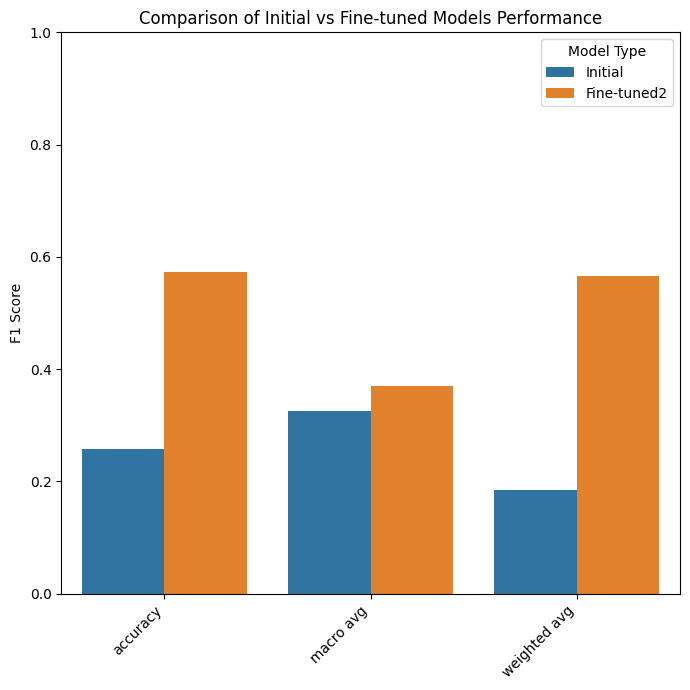

In [223]:
plt.figure(figsize=(7, 7))
sns.barplot(x='label', y='f1_score', hue='type', data=df_performance_melted2)

plt.title('Comparison of Initial vs Fine-tuned Models Performance')
plt.xlabel('')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title='Model Type')
plt.tight_layout()
plt.show()

In [224]:
df_plot2 = linkedin_dept2_merge[
    (linkedin_dept2_merge['label'] != 'accuracy') &
    (linkedin_dept2_merge['label'] != 'macro avg') &
    (linkedin_dept2_merge['label'] != 'weighted avg')
].copy()

df_melted2 = df_plot2.melt(id_vars='label', var_name='type', value_name='F1 Score')

df_melted2['type'] = df_melted2['type'].replace({'initial_f1_score': 'Initial', 'finetune2_f1_score': 'Fine-tuned2'})

df_melted2

,label,type,F1 Score
0,Administrative,Initial,0.111111
1,Business Development,Initial,0.274510
2,Consulting,Initial,0.476190
3,Customer Support,Initial,0.000000
4,Human Resources,Initial,0.521739
5,Information Technology,Initial,0.238482
6,Marketing,Initial,0.320988
7,Other,Initial,0.022792
8,Project Management,Initial,0.534884
9,Purchasing,Initial,0.608696


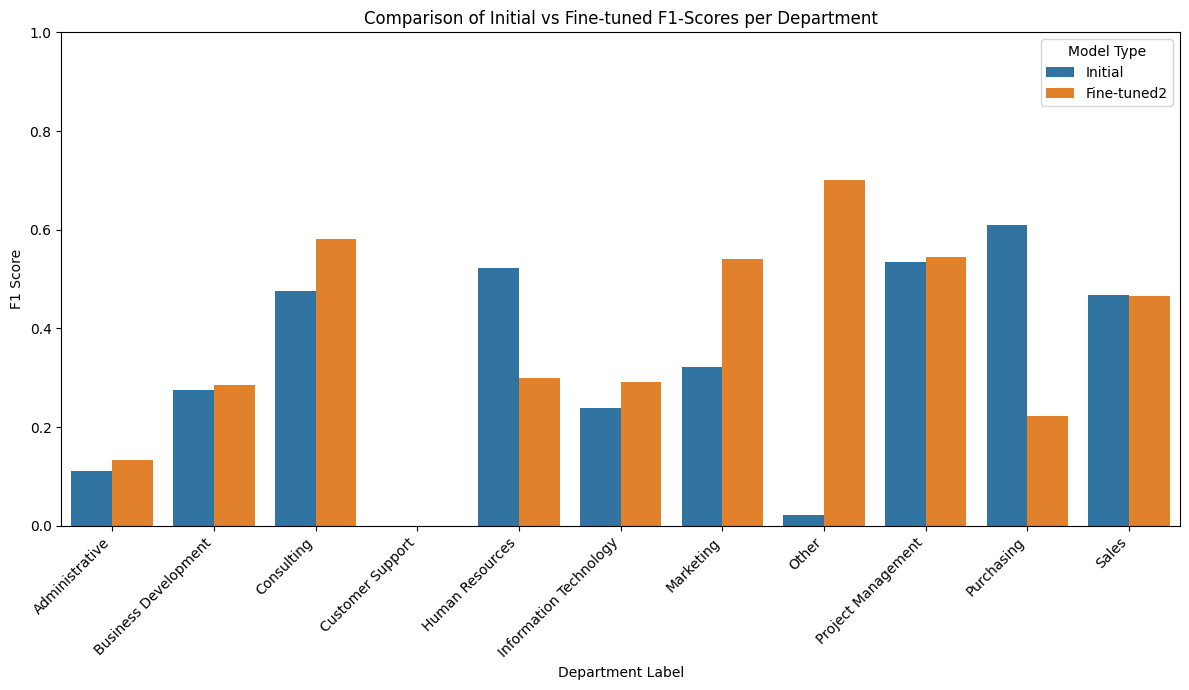

In [225]:
plt.figure(figsize=(12, 7))
sns.barplot(x='label', y='F1 Score', hue='type', data=df_melted2,)

plt.title('Comparison of Initial vs Fine-tuned F1-Scores per Department')
plt.xlabel('Department Label')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend(title='Model Type')
plt.tight_layout()
plt.show()

##Prediction for unannotated LinkedIn file

In [228]:
df_predict

,organization,linkedin,position,startDate,endDate,status
0,"Keeping The Books, Bookkeeping",,Bookkeeper,2023-03,None,ACTIVE
1,Playful Paws,,Co-Owner,2018-11,None,ACTIVE
2,S&R services,,Logistics Officer,2019-09,2024-04,INACTIVE
3,ABC Supply Co. Inc.,https://www.linkedin.com/company/abc-supply,Truck driver/ laborer,2019-03,2019-09,INACTIVE
4,MB Railways,,Fuel Driver,2018-03,2019-03,INACTIVE
...,...,...,...,...,...,...
1881,Euler Hermes Deutschland,https://www.linkedin.com/company/allianz-trade...,Juristischer Berater,1996-03,None,ACTIVE
1882,Folkwang Universität der Künste,,"Leitung Personal, Finanzen, Einkauf, IT | Folk...",2015-07,None,ACTIVE
1883,Landesspracheninstitut in der Ruhr-Universität...,,Verwaltungsleitung Landesspracheninstitut in d...,2005-10,2015-06,INACTIVE
1884,Folkwang Universität der Künste,,"Leitung Gebäudemanagement, Einkauf und Control...",2004-03,2005-09,INACTIVE


In [229]:
df_predict2_emb = model.encode(df_predict['position'].tolist())
df_predict['predict_label_dept'] = mlpc_dept2_aug.predict(df_predict2_emb)
df_predict

,organization,linkedin,position,startDate,endDate,status,predict_label_dept
0,"Keeping The Books, Bookkeeping",,Bookkeeper,2023-03,None,ACTIVE,Sales
1,Playful Paws,,Co-Owner,2018-11,None,ACTIVE,Other
2,S&R services,,Logistics Officer,2019-09,2024-04,INACTIVE,Other
3,ABC Supply Co. Inc.,https://www.linkedin.com/company/abc-supply,Truck driver/ laborer,2019-03,2019-09,INACTIVE,Other
4,MB Railways,,Fuel Driver,2018-03,2019-03,INACTIVE,Other
...,...,...,...,...,...,...,...
1881,Euler Hermes Deutschland,https://www.linkedin.com/company/allianz-trade...,Juristischer Berater,1996-03,None,ACTIVE,Information Technology
1882,Folkwang Universität der Künste,,"Leitung Personal, Finanzen, Einkauf, IT | Folk...",2015-07,None,ACTIVE,Information Technology
1883,Landesspracheninstitut in der Ruhr-Universität...,,Verwaltungsleitung Landesspracheninstitut in d...,2005-10,2015-06,INACTIVE,Sales
1884,Folkwang Universität der Künste,,"Leitung Gebäudemanagement, Einkauf und Control...",2004-03,2005-09,INACTIVE,Purchasing


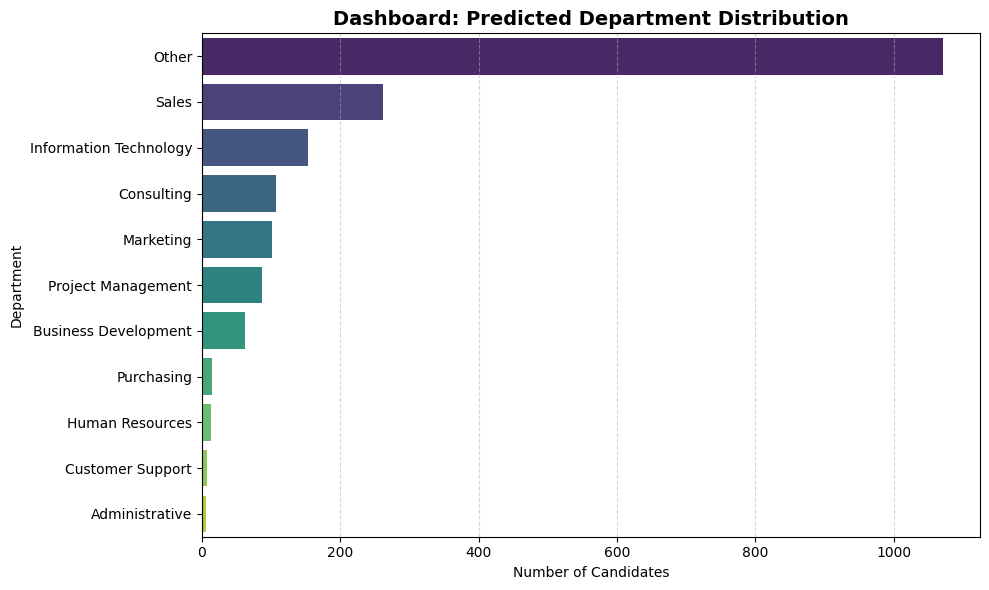

In [230]:
dept_counts = df_predict['predict_label_dept'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=dept_counts.values, y=dept_counts.index, palette='viridis', hue=dept_counts.index, legend=False)

plt.title('Dashboard: Predicted Department Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Candidates')
plt.ylabel('Department')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Fine-tuning seniority prediction (failed)

experiment first on linkedin file

##Pseudo Labels from text-matched model

In [125]:
df_pseudo_seni = df_linkedin_textmatch.copy()
df_pseudo_seni

,organization,linkedin,position,startDate,endDate,status,department,seniority,predict_label_dept,predict_label_seni
0,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokurist,2019-08,None,active,Other,Management,Other,Other
1,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management,Other,Other
2,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,betriebswirtin,2019-07,None,active,Other,Professional,Other,Other
3,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,prokuristin,2019-07,None,active,Other,Management,Other,Other
4,depot4design gmbh,https://www.linkedin.com/company/depot4design-...,cfo,2019-07,None,active,Other,Management,Other,Other
...,...,...,...,...,...,...,...,...,...,...
2632,malteserorden,,kanzler der deutschen assoziation,2015-01,None,active,Other,Management,Other,Other
2633,bistum,,justitiar,2014-03,None,active,Other,Professional,Information Technology,Other
2634,foresta management,,geschäftsführer,2010-01,None,active,Other,Management,Other,Management
2635,malteser hilfsdienst,https://www.linkedin.com/company/malteser-hilf...,präsidium,1999,None,active,Other,Management,Other,Other


In [126]:
df_pseudo_seni['predict_label_seni'].value_counts()

,count
predict_label_seni,
Other,240
Management,164
Senior,127
Lead,70
Junior,20
Director,2


In [127]:
df_pseudo_seni = df_pseudo_seni[['position', 'predict_label_seni']]

df_pseudo_seni = df_pseudo_seni.rename(columns={
    'position': 'text',
    'predict_label_seni': 'label'
})

df_pseudo_seni

,text,label
0,prokurist,Other
1,cfo,Other
2,betriebswirtin,Other
3,prokuristin,Other
4,cfo,Other
...,...,...
2632,kanzler der deutschen assoziation,Other
2633,justitiar,Other
2634,geschäftsführer,Management
2635,präsidium,Other


In [128]:
df_seniority

,text,label
0,analyst,Junior
1,analyste financier,Junior
2,anwendungstechnischer mitarbeiter,Junior
3,application engineer,Senior
4,applications engineer,Senior
...,...,...
9423,vp sales d.a.ch.,Management
9424,vp sales dach,Management
9425,vp sales development & strategy,Management
9426,vp sales germany,Management


In [129]:
df_seni = df_seniority.copy()
df_seni_aug = pd.concat([df_seni, df_pseudo_seni])
df_seni_aug


,text,label
0,analyst,Junior
1,analyste financier,Junior
2,anwendungstechnischer mitarbeiter,Junior
3,application engineer,Senior
4,applications engineer,Senior
...,...,...
2632,kanzler der deutschen assoziation,Other
2633,justitiar,Other
2634,geschäftsführer,Management
2635,präsidium,Other


In [130]:
X_train_seni_aug, X_test_seni_aug, y_train_seni_aug, y_test_seni_aug = emb_split(df_seni_aug, model, 0.2)

In [131]:
mlpc_seni_aug = clone(mlpc_finetuned)
mlpc_seni_aug.fit(X_train_seni_aug, y_train_seni_aug)

MLPClassifier(alpha=0.05, hidden_layer_sizes=(50,), max_iter=500,
              random_state=42)

In [132]:
mlpc_seni_aug_report =  evaluation_report(mlpc_seni_aug, X_test_seni_aug, y_test_seni_aug)

pd.DataFrame(mlpc_seni_aug_report).T


,precision,recall,f1-score,support
Director,0.935000,0.958974,0.946835,195.000000
Junior,0.927083,0.864078,0.894472,103.000000
Lead,0.964132,0.968300,0.966211,694.000000
Management,0.919540,0.860215,0.888889,186.000000
Other,0.740000,0.685185,0.711538,54.000000
Senior,0.954660,0.973042,0.963764,779.000000
accuracy,0.946295,0.946295,0.946295,0.946295
macro avg,0.906736,0.884966,0.895285,2011.000000
weighted avg,0.945598,0.946295,0.945720,2011.000000


##LinkedIn seniority prediction

In [133]:
linkedin_emb = model.encode(df_linkedin['position'].tolist())

mlcp_linkedin_seni_aug_report = evaluation_report(mlpc_seni_aug, linkedin_emb, df_linkedin['seniority'])

linkedin_seni_finetune = pd.DataFrame(mlcp_linkedin_seni_aug_report).T
linkedin_seni_finetune

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

,precision,recall,f1-score,support
Director,0.560976,0.676471,0.613333,34.000000
Junior,0.277778,0.416667,0.333333,12.000000
Lead,0.825000,0.528000,0.643902,125.000000
Management,0.880597,0.614583,0.723926,192.000000
Other,0.000000,0.000000,0.000000,0.000000
Professional,0.000000,0.000000,0.000000,216.000000
Senior,0.177305,0.568182,0.270270,44.000000
accuracy,0.380417,0.380417,0.380417,0.380417
macro avg,0.388808,0.400557,0.369252,623.000000
weighted avg,0.485405,0.380417,0.411279,623.000000


## Prediction for unannotated LinkedIn file

In [134]:
df_predict

,organization,linkedin,position,startDate,endDate,status,predict_label_dept
0,"keeping the books, bookkeeping",,bookkeeper,2023-03,None,active,Other
1,playful paws,,co-owner,2018-11,None,active,Other
2,s&r services,,logistics officer,2019-09,2024-04,inactive,Other
3,abc supply co. inc.,https://www.linkedin.com/company/abc-supply,truck driver/ laborer,2019-03,2019-09,inactive,Other
4,mb railways,,fuel driver,2018-03,2019-03,inactive,Other
...,...,...,...,...,...,...,...
1881,euler hermes deutschland,https://www.linkedin.com/company/allianz-trade...,juristischer berater,1996-03,None,active,Other
1882,folkwang universität der künste,,"leitung personal, finanzen, einkauf, it | folk...",2015-07,None,active,Purchasing
1883,landesspracheninstitut in der ruhr-universität...,,verwaltungsleitung landesspracheninstitut in d...,2005-10,2015-06,inactive,Other
1884,folkwang universität der künste,,"leitung gebäudemanagement, einkauf und control...",2004-03,2005-09,inactive,Purchasing


In [135]:
df_predict['predict_label_seni'] = mlpc_seni_aug.predict(df_predict_emb)
df_predict

,organization,linkedin,position,startDate,endDate,status,predict_label_dept,predict_label_seni
0,"keeping the books, bookkeeping",,bookkeeper,2023-03,None,active,Other,Other
1,playful paws,,co-owner,2018-11,None,active,Other,Management
2,s&r services,,logistics officer,2019-09,2024-04,inactive,Other,Senior
3,abc supply co. inc.,https://www.linkedin.com/company/abc-supply,truck driver/ laborer,2019-03,2019-09,inactive,Other,Other
4,mb railways,,fuel driver,2018-03,2019-03,inactive,Other,Other
...,...,...,...,...,...,...,...,...
1881,euler hermes deutschland,https://www.linkedin.com/company/allianz-trade...,juristischer berater,1996-03,None,active,Other,Lead
1882,folkwang universität der künste,,"leitung personal, finanzen, einkauf, it | folk...",2015-07,None,active,Purchasing,Lead
1883,landesspracheninstitut in der ruhr-universität...,,verwaltungsleitung landesspracheninstitut in d...,2005-10,2015-06,inactive,Other,Lead
1884,folkwang universität der künste,,"leitung gebäudemanagement, einkauf und control...",2004-03,2005-09,inactive,Purchasing,Lead


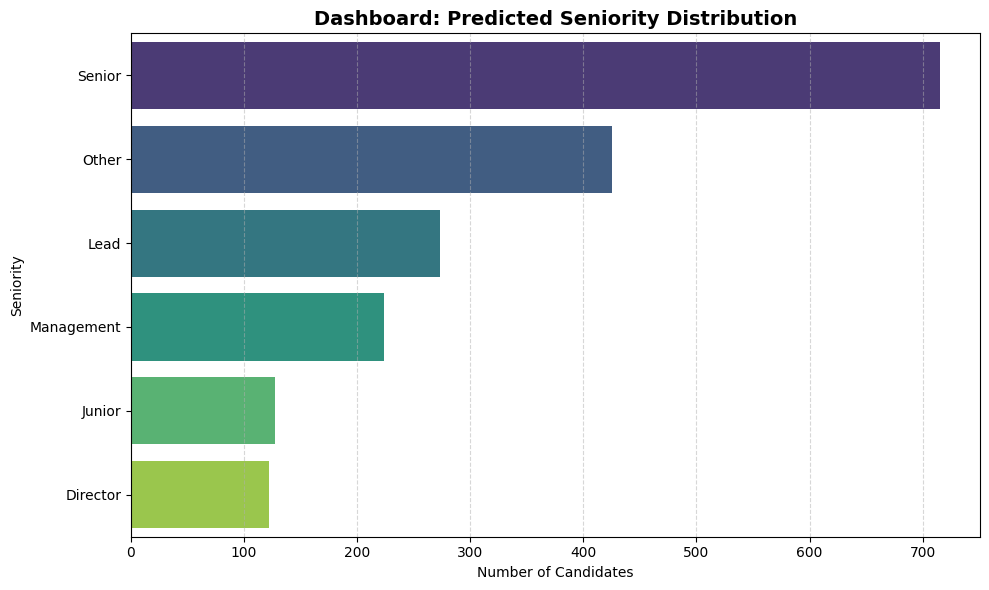

In [136]:
seni_counts = df_predict['predict_label_seni'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=seni_counts.values, y=seni_counts.index, palette='viridis', hue=seni_counts.index, legend=False)

plt.title('Dashboard: Predicted Seniority Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Number of Candidates')
plt.ylabel('Seniority')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()